# QlikSense data extracted for AL6

Grouped by Calendar Day and shift name

SHIFT NAMES

|Abbr.|German|English|Start Time|
|-----|------|------|------|
|FRUE|FRUEH|EARLY|06:00|
|SPAE|SPAETE|LATE|14:00|
|NACH|NACHT|NIGHT|22:00|


```
OEE -  ( $(vKPI_Useful_Time) ) / ( $(vKPI_Net_Opening_Time) ) 
Availability -  ( $(vKPI_Operating_Time) ) / ( $(vKPI_Net_Opening_Time) )
Performance -  ( $(vKPI_Net_Time) ) / ( $(vKPI_Operating_Time) )
Quality -  ( $(vKPI_Useful_Time) ) / ( $(vKPI_Net_Time) )

```

Dataframe returned is as follows:


|#|   Column              | Dtype   | Description |
|---|  ------             |  -----  | ----------- |
| 0  | Shift Long Name    |  object | Sanofi provided Shift Long Name |
| 1  | OEE %              |   float64| Useful_Time / Net_Opening_Time |
| 2  | Availability %     |  float64| Operating_Time / Net_Opening_Time |
| 3  | Performance %      |   float64| Net_Time / Operating_Time |
| 4  | Quality %          |  object | Useful_Time / Net_Time |
| 5  | Net Opening Time   |   float64| Net_Opening_Time * 24
| 6  | Quantity (Pack)    |   float64| Quantity of good packs (36670901_CNTR_GOOD) |
| 7  | Scheduled Down     |  float64| QlikSense provided scheduled down * 24 |
| 8  | Total Potential Time|  object | QlikSense provided |
| 9  | Useful Time         |  object | Useful time from QlikSense |
| 10 | AvailxPerf          |  float64| Availability % x Performance % (validation check against provided OEE %) |
| 11 | Shift               |  category| First 4 characters of Shift Long Name |

In [10]:
import pandas as pd
import numpy as np
import os
from glob import iglob

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# my modules
import set_config
from common_functions import create_df_from_file


In [11]:
# call set_config
dir_sanofi_share = set_config.ConfigSectionMap("SectionOne")['sanofi']
dir_local = set_config.ConfigSectionMap("SectionOne")['local']

In [12]:
def qs_extract_oee():
    # QlikSense OEE Data extract
    folder = 'IP21_data'

    df_qs_oee = create_df_from_excel(dir_sanofi_share, folder, "AL6_OEE.xlsx")
    df_qs_oee['Calendar Day'] = pd.to_datetime(df_qs_oee['Calendar Day'], format='%y-%b-%d')
    df_qs_oee.set_index('Calendar Day', inplace=True)

    # calc our own OEE with Availability x Performance 
    cols = ['OEE %','Availability %','Performance %']
    df_qs_oee[cols] = df_qs_oee[cols].apply(pd.to_numeric, errors='coerce')
    df_qs_oee['AvailxPerf'] = df_qs_oee['Availability %'] * df_qs_oee['Performance %']
    cols.append('AvailxPerf')
    # df_qs_oee[cols] = df_qs_oee[cols].mul(100)

    df_qs_oee['Shift'] = pd.Categorical(df_qs_oee['Shift Long Name'].str[:4])

    df_qs_oee['Quantity (Pack)'] = df_qs_oee['Quantity (Pack)'].apply(pd.to_numeric, errors='coerce')

    df_qs_oee[cols] = round(df_qs_oee[cols],2)
    # df_qs_oee[(df_qs_oee['OEE %'] - df_qs_oee['AvailxPerf'] !=0) & (df_qs_oee['OEE %'].isna() == False) ][cols]

    return df_qs_oee

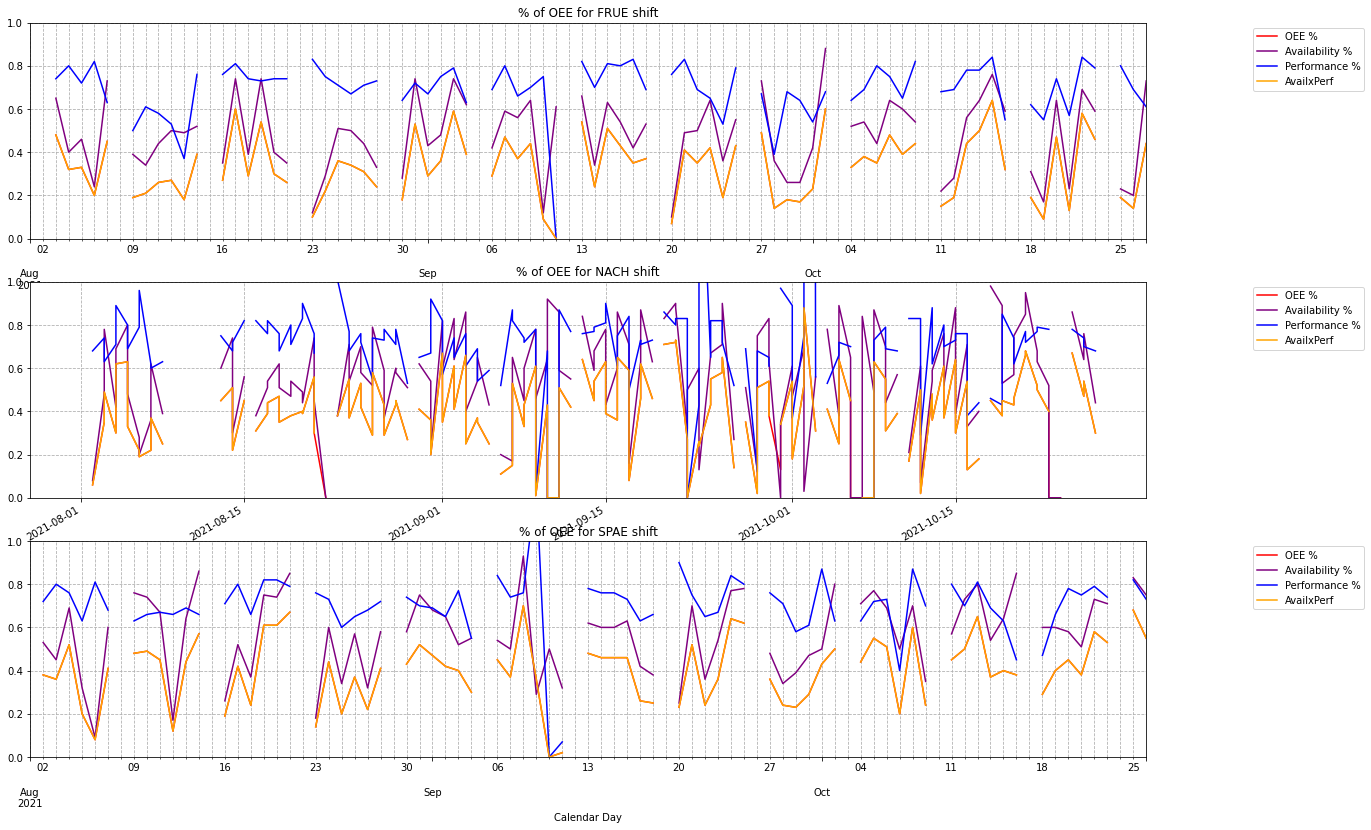

In [13]:
if __name__ == '__main__':

    %matplotlib inline

    df_qs_oee = qs_extract_oee()

    shifts = df_qs_oee['Shift'].unique()

    fig, axs = plt.subplots(len(shifts), 1, figsize=(20, 15))

    colors = ("red", "purple", "blue", "orange")

    # cols = ['OEE %','McL_OEE']
    cols = ['OEE %','Availability %','Performance %','AvailxPerf']

    i=0

    for s in shifts:
        data = df_qs_oee[df_qs_oee.Shift == s]
        # data.set_index('Calendar Day', inplace=True)
        x=0
        for c in cols:

            data[c].plot(ax=axs[i], c=colors[x])
            # data['Quantity (Pack)'].plot(secondary_y=True, ax=axs[i])
            # set the limits
            axs[i].set_ylim(0,1)
            axs[i].grid(True,which="both", linestyle='--')
            axs[i].set_title('% of OEE for {} shift'.format(s))
            axs[i].legend(loc='upper right', bbox_to_anchor=(1.20, 1.0), fancybox=True)
            x+=1

        i+=1

In [14]:
df_qs_oee.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2021-08-01 to 2021-10-27
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Line                   350 non-null    object  
 1   Shift Long Name        350 non-null    object  
 2   OEE %                  290 non-null    float64 
 3   Availability %         290 non-null    float64 
 4   Performance %          284 non-null    float64 
 5   Quality %              350 non-null    object  
 6   Net Opening Time       350 non-null    float64 
 7   Quantity (Pack)        282 non-null    float64 
 8   Scheduled Down         350 non-null    float64 
 9   Total Potential Time   350 non-null    object  
 10  Useful Time            350 non-null    object  
 11  Operating Time         350 non-null    object  
 12  Net Time               350 non-null    object  
 13  Duration (min)         350 non-null    float64 
 14  Frequency (stop./day)  

In [15]:
df_qs_oee.groupby([pd.Grouper(freq='D'), 'Shift'])['Quantity (Pack)'].sum()

Calendar Day  Shift
2021-08-01    FRUE         0.0
              NACH     19152.0
              SPAE         0.0
2021-08-02    FRUE         0.0
              NACH      1022.0
                        ...   
2021-10-26    NACH     26637.0
              SPAE     39561.0
2021-10-27    FRUE     21700.0
              NACH     16145.0
              SPAE         0.0
Name: Quantity (Pack), Length: 264, dtype: float64